#  Eigenvalues and Eigenvectors

Welcome to the last assignment of this course and congratulations for making it this far. In this final assignment you will use your knowledge of linear algebra and your skills using Python and NumPy to address some real-world scenarios where linear algebra is actually used to solve and simplify problems.

**After this assignment you will be able to:**
- apply linear transformations, eigenvalues and eigenvectors in a webpage navigation model
- apply PCA on a dataset to reduce its dimensions

# Table of Contents
- [ 1 - Application of Eigenvalues and Eigenvectors: Navigating Webpages](#1)
  - [ Exercise 1](#ex01)
  - [ Exercise 2](#ex02)
- [ 2 - Application of Eigenvalues and Eigenvectors: Principal Component Analysis](#2)
  - [2.1 Load the data](#2.1)
  - [2.2 Get the covariance matrix](#2.2)
    - [ Exercise 3](#ex03)
    - [ Exercise 4](#ex04)
  - [ 2.3 - Compute the eigenvalues and eigenvectors](#2.3)
  - [ 2.4 Transform the centered data with PCA](#2.4)
    - [ Exercise 5](#ex05)
  - [ 2.5 Analizing the dimensionality reduction in 2 dimensions](#2.5)
  - [ 2.6 Reconstructing the images from the eigenvectors](#2.6)
  - [ 2.7 Explained variance](#2.7)

## Packages

Run the following cell to load the packages you'll need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg

Load the utils module and the unit tests defined for this notebook.

In [2]:
import utils
import w4_unittest

<a name='1'></a>
## 1 - Application of Eigenvalues and Eigenvectors: Navigating Webpages

As you learned in the lectures, eigenvalues and eigenvectors play a very important role in what's called (discrete) dynamical systems. As you might recall, a **discrete dynamical system** descibes a system where, as time goes by, the state changes according to some process. When defining this dynamical systems you could represent all the possible states, such as sunny, rainy or cloudy, in a vector called the **state vector**. 

Each discrete dynamical system can me represented by a transition matrix $P$, which indicates, given a particular state, what are the chances or probabilities of moving to each of the other states. This means the element $(2,1)$ of the matrix represents the probability of transitioning from state $1$ to state $2$.
 
Starting with an initial state $X_0$, the transition to the next state $X_1$ is a linear transformation defined by the transition matrix $P$: $X_1=PX_0$. That leads to $X_2=PX_1=P^2X_0$, $X_3=P^3X_0$, and so on. This implies that $X_t=PX_{t-1}$ for $t=0,1,2,3,\ldots$. In other words, we can keep multiplying by `P` to move from one state to the next.

One application of discrete dynamical systems is to model browsing web pages. Web pages often contain links to other pages, so the dynamical system would model how a user goes from one page to another by hopping from link to link. For simplicity, assume that the browser is only following links to a new page rather than navigating to an unlinked one. 

In this case, the state vector $X_t$ will be the probabilities that the browser is on a particular page at time $t$. Navigation from one page to another advances the model from one state vector $X_{t-1}$ to another state vector $X_t$. A linear transformation, defined by a matrix $P$, will have entries $p_{ij}$ with the probabilities that the browser navigates to page $j$ from page $i$. For fixed column $j$, the entries represent a probability distribution describing location of the browser at the next step, given that you are at state $j$. Thus, the entries in each column must add to 1.

<a name='ex01'></a>
### Exercise 1

For the sake of the example, consider there are only a small number of pages $n=5$. This means that the transition matrix $P$ will be a $5 \times 5$ matrix. In this particular case, all elements on the main diagonal should be equal to $0$, since we are making the reasonable assumption that there is no existing link to the current page. Also, as metioned before, all the entries in each column must add to one. Here is an example of such a matrix for $n=5$:

$$P=
\begin{bmatrix}
0    & 0.75 & 0.35 & 0.25 & 0.85 \\
0.15 & 0    & 0.35 & 0.25 & 0.05 \\
0.15 & 0.15 & 0    & 0.25 & 0.05 \\
0.15 & 0.05 & 0.05 & 0    & 0.05 \\
0.55 & 0.05 & 0.25 & 0.25 & 0
\end{bmatrix}\tag{5}
$$

Define vector $X_0$, so the browser starts navigation at page $4$ ($X_0$ is a vector with a single entry equal to one, and all other entries equal to zero). Apply the transformation once: $X_1=PX_0$ to find a vector of the probabilities that the browser is at each of four pages.

In [6]:
### START CODE HERE ###
P = np.array([
    
    [0, 0.75, 0.35, 0.25, 0.85],
    [0.15, 0, 0.35, 0.25, 0.05],
    [0.15, 0.15, 0, 0.25, 0.05],
    [0.15, 0.05, 0.05, 0, 0.05],
    [0.55, 0.05, 0.25, 0.25, 0]
]) 

X0 = np.array([[0], [0], [0], [1], [0]])
# Multiply matrix P and X_0 (matrix multiplication).
X1 = P@X0

### END CODE HERE ###
print(f'Sum of columns of P: {sum(P)}')
print(f'X1:\n{X1}')

Sum of columns of P: [1. 1. 1. 1. 1.]
X1:
[[0.25]
 [0.25]
 [0.25]
 [0.  ]
 [0.25]]


##### __Expected Output__

```Python
Sum of columns of P: [1. 1. 1. 1. 1.]
X1:
[[0.25]
 [0.25]
 [0.25]
 [0.  ]
 [0.25]]
```

In [7]:
# Test your solution.
w4_unittest.test_matrix(P, X0, X1)

 All tests passed


Applying the transformation $m$ times you can find a vector $X_m$ with the probabilities of the browser being at each of the pages after $m$ steps of navigation.

In [8]:
X = np.array([[0],[0],[0],[1],[0]])
m = 20

for t in range(m):
    X = P @ X
    
print(X)

[[0.39392366]
 [0.13392366]
 [0.11407667]
 [0.0850993 ]
 [0.27297672]]


It is useful to predict the probabilities in $X_m$ when $m$ is large, and thus determine what pages a browser is more likely to visit after a long period of browsing the web. In other words, we want to know which pages ultimately get the most traffic. One way to do that is just apply the transformation many times, and with this small $5 \times 5$ example you can do that just fine. In real life problems, however, you'll have enormous matrices and doing so will be computationally expensive. Here is where eigenvalues and eigenvectors can help here significantly reducing the amount of calculations. Let's see how!

Begin by finding eigenvalues and eigenvectors for the previously defined matrix $P$:

In [9]:
eigenvals, eigenvecs = np.linalg.eig(P)
print(f'Eigenvalues of P:\n{eigenvals}\n\nEigenvectors of P\n{eigenvecs}')

Eigenvalues of P:
[ 1.         -0.70367062  0.00539505 -0.08267227 -0.21905217]

Eigenvectors of P
[[-0.76088562 -0.81362074  0.10935376  0.14270615 -0.39408574]
 [-0.25879453  0.050269   -0.6653158   0.67528802 -0.66465044]
 [-0.2204546   0.07869601 -0.29090665  0.17007443  0.35048734]
 [-0.1644783   0.12446953  0.19740707 -0.43678067  0.23311487]
 [-0.52766004  0.56018621  0.64946163 -0.55128793  0.47513398]]


As you can see, there is one eigenvalue with value $1$, and the other four have an aboslute values smaller than 1. It turns out this is a property of transition matrices. In fact, they have so many properties that these types of matrices fall into a category of matrices called **Markov matrix**. 

In general, a square matrix whose entries are all nonnegative, and the sum of the elements for each column is equal to $1$ is called a **Markov matrix**. Markov matrices have a handy property - they always have an eigenvalue equal to 1. As you learned in the lectues, in the case of transition matricies, the eigenvector associated with the eigenvalue $1$ will determine the state of the model in the long run , after evolving for a long period of time. 

You can easily verify that the matrix $P$ you defined earlier is in fact a Markov matrix. 
So, if $m$ is large enough, the equation $X_m=PX_{m-1}$ can be rewritten as $X_m=PX_{m-1}=1\times X_m$. This means that predicting probabilities at time $m$, when $m$ is large you can simply just look for an eigenvector corresponding to the eigenvalue $1$. 

So, let's extract the eigenvector associated to the eigenvalue $1$. 

In [10]:
X_inf = eigenvecs[:,0]

print(f"Eigenvector corresponding to the eigenvalue 1:\n{X_inf[:,np.newaxis]}")

Eigenvector corresponding to the eigenvalue 1:
[[-0.76088562]
 [-0.25879453]
 [-0.2204546 ]
 [-0.1644783 ]
 [-0.52766004]]


<a name='ex02'></a>
### Exercise 2

Just to verify the results, perform matrix multiplication $PX$ (multiply matrix `P` and vector `X_inf`) to check that the result will be equal to the vector $X$ (`X_inf`).

In [12]:
# This is organised as a function only for grading purposes.
def check_eigenvector(P, X_inf):
    ### START CODE HERE ###
    X_check = P@X_inf
    ### END CODE HERE ###
    return X_check

X_check = check_eigenvector(P, X_inf)
print("Original eigenvector corresponding to the eigenvalue 1:\n" + str(X_inf))
print("Result of multiplication:" + str(X_check))

# Function np.isclose compares two NumPy arrays element by element, allowing for error tolerance (rtol parameter).
print("Check that PX=X element by element:" + str(np.isclose(X_inf, X_check, rtol=1e-10)))

Original eigenvector corresponding to the eigenvalue 1:
[-0.76088562 -0.25879453 -0.2204546  -0.1644783  -0.52766004]
Result of multiplication:[-0.76088562 -0.25879453 -0.2204546  -0.1644783  -0.52766004]
Check that PX=X element by element:[ True  True  True  True  True]


In [14]:
# Test your solution.
w4_unittest.test_check_eigenvector(check_eigenvector)

 All tests passed


This result gives the direction of the eigenvector, but as you can see the entries can't be interpreted as probabilities since you have negative values, and they don't add to 1. That's no problem. Remember that by convention `np.eig` returns eigenvectors with norm 1, but actually any vector on the same line is also an eigenvector to the eigenvaue 1, so yo can simply scale the vector so that all entries are positive and add to one.This will give you the long-run probabilities of landing on a given web page.

In [15]:
X_inf = X_inf/sum(X_inf)
print(f"Long-run probabiltites of being at each webpage:\n{X_inf[:,np.newaxis]}")

Long-run probabiltites of being at each webpage:
[[0.39377747]
 [0.13393269]
 [0.11409081]
 [0.08512166]
 [0.27307736]]


This means that after navigating the web for a long time, the probability that the browser is at page 1 is 0.394, of being on page 2 is 0.134, on page 3 0.0114, on page 4 0.085, and finally page 5 has a probability of 0.273.

Looking at this result you can conclude that page 1 is the most likely for the browser to be at, while page 4 is the least probable one.

If you compare the result of `X_inf` with the one you got after evolving the systems 20 times, they are the same up to the third decimal!

Here is a fun fact, this type of a model was the foundation of the PageRank algorithm, which is the basis of Google's very successful search engine.

<a name='2'></a>
## 2 - Application of Eigenvalues and Eigenvectors: Principal Component Analysis

As you learned in the lectures, one of the useful applications of eigenvalues and eigenvectors is the dimensionality reduction algorithm called Principal Component Analyisis, or PCA for short.

In this second section of the assignment you will be applying PCA on an image dataset to perform image compression. 

You will be using a portion of the [Cat and dog face](https://www.kaggle.com/datasets/alessiosanna/cat-dog-64x64-pixel/data) dataset from Kaggle. In particular, you will be using the cat images.

Remember that to apply PCA on any dataset you will begin by defining the covariance matrix. After that you will compute the eigenvalues and eigenvectors of this covariance matrix. Each of these eigenvectors will be a **principal component**. To perfrom the dimensionality reduction, you will take the $k$ principal components associated to the $k$ biggest eigenvalues, and transform the original data by projecting it onto the direction of these principal components (eigenvectors).

<a name='2.1'></a>
### 2.1 - Load the data
Begin by loading the images and transforming them to black and withe using `load_images` function from utils. 

In [16]:
imgs = utils.load_images('./data/')

`imgs` should be a list, where each element of the list is an array (matrix). Let's check it out

In [17]:
height, width = imgs[0].shape

print(f'\nYour dataset has {len(imgs)} images of size {height}x{width} pixels\n')


Your dataset has 55 images of size 64x64 pixels



Go ahead and plot one image to see what they look like. You can use the colormap 'gray' to plot in black and white. Feel free to look into as many pictures as you want.

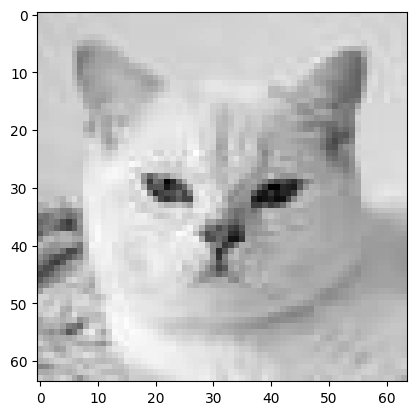

In [19]:
plt.imshow(imgs[0], cmap='gray')

When working with images, you can consider each pixel as a variable. Having each image in matrix form is good for visualizing the image, but not so much for operating on each variable. 

In order to apply PCA for dimensionality reduction you will need to flatten each image into a single row vector. You can do this using the `reshape` function from NumPy. 

The resulting array will have 55 rows, one for each image, and 64x64=4096 columns.

In [20]:
imgs_flatten = np.array([im.reshape(-1) for im in imgs])

print(f'imgs_flatten shape: {imgs_flatten.shape}')

imgs_flatten shape: (55, 4096)


<a name='2.2'></a>
## 2.2 - Get the covariance matrix

Now that you have the images in the correct shape you are ready to apply PCA on the flattened dataset. 

If you consider each pixel (column) as a variable, and each image (rows) as an obervation you will have 55 observations of 4096 variables, $X_1, X_2, \ldots, X_{4096}$ so that
$$\mathrm{imgs\_flatten} = \begin{bmatrix} x_{1,1} & x_{1,2} & \ldots & x_{1,4096}\\
                                           x_{2,1} & x_{2,2} & \ldots & x_{2,4096} \\
                                           \vdots & \vdots & \ddots & \vdots \\
                                           x_{55,1} & x_{55,2} & \ldots & x_{55,4096}\end{bmatrix}$$


As you might remember from the lectures, to compute PCA you first need to find the covariance matrix


$$\Sigma = \begin{bmatrix}Var(X_1) & Cov(X_1, X_2) & \ldots & Cov(X_1, X_{4096}) \\
                          Cov(X_1, X_2) & Var(X_2) & \ldots & Cov(X_2, X_{4096})\\
                          \vdots & \vdots & \ddots & \vdots \\
                          Cov(X_1,X_{4096}) & Cov(X_2, X_{4096}) &\ldots & Var(X_{4096})\end{bmatrix}$$

<a name='ex03'></a>
### Exercise 3

In order to get the covariance matrix you first need to center the data by subtracting the mean for each variable (column). 

As you've seen in the lectures, the centered data matrix looks something like this:

$$X = \begin{bmatrix} (x_{1,1}- \mu_1) & (x_{1,2}- \mu_2) & \ldots & (x_{1,4096}- \mu_{4096})\\
                                           (x_{2,1}- \mu_1) & (x_{2,2}- \mu_2) & \ldots & (x_{2,4096}- \mu_{4096}) \\
                                           \vdots & \vdots & \ddots & \vdots \\
                                           (x_{55,1}- \mu_1) & (x_{55,2}- \mu_2) & \ldots & (x_{55,4096}- \mu_{4096})\end{bmatrix}$$

From the lectures you know that, for example, the mean of the first variable (pixel) can be found as the mean of all the observations: $\mu_1 = \frac{1}{55} \sum_{i=1}^{55} x_{i,1}$.


For the following exercise you will implement a function that takes an array of shape $\mathrm{Num. observations}\times\mathrm{Num. variables}$, and returns the centered data. 

To perfrom the centering you will need three numpy functions. Click on their names if you want to read the official documentation for each in more detail:
- [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html): use this function to compute the mean of each variable, just remember to pass the correct `axis` argument.
- [`np.repeat`](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html#numpy-repeat): This will allow for you to repeat the values of each $\mu_i$ . 
- [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy-reshape): Use this function to reshape the repeated values into a matrix of shape the same size as your input data. To get the correct matrix after the reshape, remember to use the parameter `order='F'`.

In [27]:
def center_data(Y):
    """
    Center your original data
    Args:
         Y (ndarray): input data. Shape (n_observations x n_pixels)
    Outputs:
        X (ndarray): centered data
    """
    ### START CODE HERE ###
    # Compute the mean of Y along the 0th axis
    mean_vector = np.mean(Y, axis=0)
    
    # Repeat the mean_vector n_observations times
    mean_matrix = np.repeat(mean_vector, Y.shape[0])
    
    # Reshape the mean_matrix into the same shape as Y
    mean_matrix = np.reshape(mean_matrix, Y.shape, order='F')
    
    # Subtract the mean_matrix from Y to center the data
    X = Y - mean_matrix
    ### END CODE HERE ###
    return X

Go ahead and apply the `center_data` function to your data in `imgs_flatten`. 

You can also print the image again and check that the face of the cat still looks the same. This is because the color scale is not fixed, but rather relative to the values of the pixels. 

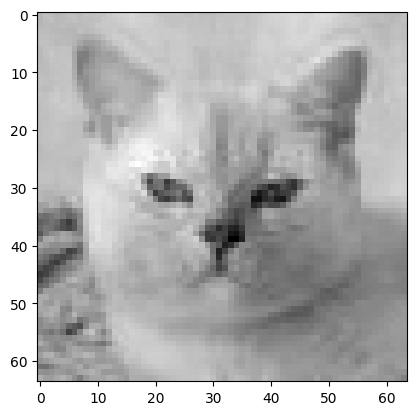

In [28]:
X = center_data(imgs_flatten)
plt.imshow(X[0].reshape(64,64), cmap='gray')

In [29]:
# Test your solution.
w4_unittest.test_center_data(center_data)

 All tests passed


### Exercise 4

Now that you have your centered data, $X$, you can go ahead and find the covariance matrix 

You might remember from the lectures that once you have your centered data, the covariance matrix can be found by appliying the dot product between $X^T$ and $X$, and divide by the number of observations minus 1.

To perform the dot product you can simply use the function [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html#numpy-dot).


In [ ]:
def get_cov_matrix(X):
    """ Calculate covariance matrix from centered data X
    Args:
        X (np.ndarray): centered data matrix
    Outputs:
        cov_matrix (np.ndarray): covariance matrix
    """

    ### START CODE HERE ###
    cov_matrix = None
    cov_matrix = None
    ### END CODE HERE ###
    
    return cov_matrix

In [ ]:
cov_matrix = get_cov_matrix(X)

Check the dimensions of the covariance matrix, it should be a square matrix with 4096 rows and columns. 

In [ ]:
print(f'Covariance matrix shape: {cov_matrix.shape}')

In [ ]:
# Test your solution.
w4_unittest.test_cov_matrix(get_cov_matrix)

<a name='2.3'></a>
### 2.3 - Compute the eigenvalues and eigenvectors
Now you are all set compute the eigenvalues and eigenvectors of the covariance matrix.
Due to performance constaints, you will not be using `np.linalg.eig`, but rather the very similar function [`scipy.sparse.linalg.eigsh`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html), which exploits the fact that $\mathrm{cov\_matrix}^T=\mathrm{cov\_matrix}$. Also, this function allows you to compute fewer number of eigenvalue-eigenvector pairs. 

It is outside of the scope of this course, but it can be shown that at most 55 eigenvalues of `cov_matrix` will be different from zero, which is the smallest dimension of the data matrix `X`. Thus, for computational efficiency, you will only be computing the first biggest 55 eigenvalues $\lambda_1, \ldots, \lambda_{55}$ and their corresponding eigenvectors $v_1, \ldots, v_{55}$. Feel free to try changing the `k` parameter in `scipy.sparse.linalg.eigsh` to something slightly bigger, to verify that all the new eigenvalues are zero. Try to keep it below 80, otherwise it will take too long to compute. 

The outputs of this scipy function are exactly the same as the ones from `np.linalg.eig`, except eigenvalues are ordered in decreasing order, so if you want to check out the largest eigenvalue you need to look into the last position of the vector. 


In [ ]:
scipy.random.seed(7)
eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(cov_matrix, k=55)
print(f'Ten largest eigenvalues: \n{eigenvals[-10:]}')

The random seed is fixed in the code above to help ensure the same eigenvectors are calculated each time. This is because for each eigenvector, there are actually two possible outcomes with norm 1. They fall on the same line but point in opposite directions. An example of this would be the vectors 

$$\begin{bmatrix}0.25 \\0.25 \\ -0.25 \\ 0.25 \end{bmatrix} \text{and } \begin{bmatrix}-0.25 \\ -0.25 \\ 0.25 \\ -0.25 \end{bmatrix}.$$

Both possibilities are correct, but by fixing the seed you guarantee you will always get the same result. 

In order to get a consistent result with `np.linalg.eig`, you will invert the order of `eigenvals` and `eigenvecs`, so they are both ordered from largest to smallest eigenvalue.

In [ ]:
eigenvals = eigenvals[::-1]
eigenvecs = eigenvecs[:,::-1]

print(f'Ten largest eigenvalues: \n{eigenvals[:10]}')

Each of the eigenvectors you found will represent one principal components. The eigenvector associated with the largest eigenvalue will be the first principal component, the eigenvector associated with the second largest eigenvalue will be the second principal component, and so on. 

It is pretty interesting to see that each principal component usually extracts some relevant features, or patterns from each image. In the next cell you will be visualizing the first sixteen components

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for n in range(4):
    for k in range(4):
        ax[n,k].imshow(eigenvecs[:,n*4+k].reshape(height,width), cmap='gray')
        ax[n,k].set_title(f'component number {n*4+k+1}')

What can you say about each of the principal components? 

<a name='2.4'></a>
### 2.4 Transform the centered data with PCA

Now that you have the first 55 eigenvalue-eivenvector pairs, you can transform your data to reduce the dimensions. Remember that your data originally consisted of 4096 variables. Suppose you want to reduce that to just 2 dimensions, then all you need to do to perform the reduction with PCA is take the dot product between your centered data and the matrix $\boldsymbol{V}=\begin{bmatrix} v_1 & v_2 \end{bmatrix}$, whose columns are the first 2 eigenvectors, or principal components, associated to the 2 largest eigenvalues.

<a name='ex03'></a>
### Exercise 5
In the next cell you will define a function that, given the data matrix, the eigenvector matrix (always sorted according to decreasing eignevalues), and the number of principal components to use, performs PCA.

In [ ]:
# GRADED cell
def perform_PCA(X, eigenvecs, k):
    """
    Perform dimensionality reduction with PCA
    Inputs:
        X (ndarray): original data matrix. Has dimensions (n_observations)x(n_variables)
        eigenvecs (ndarray): matrix of eigenvectors. Each column is one eigenvector. The k-th eigenvector 
                            is associated to the k-th eigenvalue
        k (int): number of principal components to use
    Returns:
        Xred
    """
    
    ### START CODE HERE ### 
    V = None
    Xred = None
    ### END CODE HERE ###
    return Xred

Try out this function, reducing your data to just two components

In [ ]:
Xred2 = perform_PCA(X, eigenvecs,2)
print(f'Xred2 shape: {Xred2.shape}')

In [ ]:
# Test your solution.
w4_unittest.test_check_PCA(perform_PCA)

<a name='2.5'></a>
### 2.5 Analizing the dimensionality reduction in 2 dimensions

One cool thing about reducing your data to just two components is that you can clearly visualize each cat image on the plane. Remember that each axis on this new plane represents a linear combination of the original variables, given by the direction of the two eigenvectors.

Use the function `plot_reduced_data` in `utils`to visualize the transformed data. Each blue dot represents an image, and the number represents the index of the image. This is so you can later recover which image is which, and gain some intuition.

In [ ]:
utils.plot_reduced_data(Xred2)

If two points end up being close to each other in this representation, it is expected that the original pictures should be similar as well. 
Let's see if this is true. Consider for example the images 19, 21 and 41, which appear close to each other on the top center of the plot. Plot the corresponding cat images vertfy that they correspond to similar cats. 

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(imgs[19], cmap='gray')
ax[0].set_title('Image 19')
ax[1].imshow(imgs[21], cmap='gray')
ax[1].set_title('Image 21')
ax[2].imshow(imgs[41], cmap='gray')
ax[2].set_title('Image 41')
plt.suptitle('Similar cats')

As you can see, all three cats have white snouts and black fur around the eyes, making them pretty similar.

Now, let's choose three images that seem far appart from each other, for example image 18, on the middle right, 41 on the top center and 51 on the lower left, and also plot the images

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(imgs[18], cmap='gray')
ax[0].set_title('Image 18')
ax[1].imshow(imgs[41], cmap='gray')
ax[1].set_title('Image 41')
ax[2].imshow(imgs[51], cmap='gray')
ax[2].set_title('Image 51')
plt.suptitle('Different cats')

In this case, all three cats look really different, one being completely black, another completely white, and the the third one a mix of both colors.


Feel free to choose different pairs of points and check how similar (or different) the pictures are. 

<a name='2.6'></a>
### 2.6 Reconstructing the images from the eigenvectors

When you compress the images using PCA, you are losing some information because you are using fewer variables to represent each observation. 

A natural question arrises: how many components do you need to get a good reconstruction of the image? Of course, what determines a "good" reconstruction might depend on the application.

A cool thing is that with a simple dot product you can transform the data after applying PCA back to the original space. This means that you can reconstruct the original image from the transformed space and check how distorted it looks based on the number of components you kept.

Suppose you obtained the matrix $X_{red}$ by keeping just two eigenvectors, then $X_{red} = \mathrm{X}\underbrace{\left[v_1\  v_2\right]}_{\boldsymbol{V_2}}$.

To transform the images back to the original variables space all you need to do is take the dot product between $X_{red}$ and $\boldsymbol{V_2}^T$. If you were to keep more components, say $k$, then simply replace $\boldsymbol{V_2}$ by $\boldsymbol{V_k} = \left[v_1\ v_2\ \ldots\ v_k\right]$. Notice that you can't make any combination you like, if you reduced the original data to just $k$ components, then the recovery must consider only the first $k$ eigenvectors, otherwise you will not be able to perfrom the matrix multiplication.

In the next cell you will define a function that given the transformed data $X_{red}$ and the matrix of eigenvectors returns the recovered image. 

In [ ]:
def reconstruct_image(Xred, eigenvecs):
    X_reconstructed = Xred.dot(eigenvecs[:,:Xred.shape[1]].T)

    return X_reconstructed

Let's see what the reconstructed image looks like for different number of principal components

In [ ]:
Xred1 = perform_PCA(X, eigenvecs,1) # reduce dimensions to 1 component
Xred5 = perform_PCA(X, eigenvecs, 5) # reduce dimensions to 5 components
Xred10 = perform_PCA(X, eigenvecs, 10) # reduce dimensions to 10 components
Xred20 = perform_PCA(X, eigenvecs, 20) # reduce dimensions to 20 components
Xred30 = perform_PCA(X, eigenvecs, 30) # reduce dimensions to 30 components
Xrec1 = reconstruct_image(Xred1, eigenvecs) # reconstruct image from 1 component
Xrec5 = reconstruct_image(Xred5, eigenvecs) # reconstruct image from 5 components
Xrec10 = reconstruct_image(Xred10, eigenvecs) # reconstruct image from 10 components
Xrec20 = reconstruct_image(Xred20, eigenvecs) # reconstruct image from 20 components
Xrec30 = reconstruct_image(Xred30, eigenvecs) # reconstruct image from 30 components

fig, ax = plt.subplots(2,3, figsize=(22,15))
ax[0,0].imshow(imgs[21], cmap='gray')
ax[0,0].set_title('original', size=20)
ax[0,1].imshow(Xrec1[21].reshape(height,width), cmap='gray')
ax[0,1].set_title('reconstructed from 1 components', size=20)
ax[0,2].imshow(Xrec5[21].reshape(height,width), cmap='gray')
ax[0,2].set_title('reconstructed from 5 components', size=20)
ax[1,0].imshow(Xrec10[21].reshape(height,width), cmap='gray')
ax[1,0].set_title('reconstructed from 10 components', size=20)
ax[1,1].imshow(Xrec20[21].reshape(height,width), cmap='gray')
ax[1,1].set_title('reconstructed from 20 components', size=20)
ax[1,2].imshow(Xrec30[21].reshape(height,width), cmap='gray')
ax[1,2].set_title('reconstructed from 30 components', size=20)


As you can see, as the number of components increases, the reconstructed image looks more and more as the original one. Even with as little as 1 component you can are least identify where the relevant features such as eyes and nose are located. 

What happens when you consider all of the 55 eigenvectors associated to non-zero eigenvalues? Go ahead and experiment with different number of principal components and see what happens.

<a name='2.7'></a>
### 2.7 Explained variance

When deciding how many components to use for the dimensionality reduction, one good criteria to consider is the explained variance. 

The explained variance is measure of how much variation in a dataset can be attributed to each of the principal components (eigenvectors). In other words, it tells us how much of the total variance is “explained” by each component. 

In PCA, the first principal component, i.e. the eigenvector associated to the largest eigenvalue, is the one with greatest explained variance. As you might remember from the lectures, the goal of PCA is to reduce the dimensionality by projecting data in the directions with biggest variability. 

In practical terms, the explained variance of a principal component is the ratio between its associated eigenvalue and the sum of all the eigenvalues. So, for our example, if you want the explained variance of the first principal component you will need to do $\frac{\lambda_1}{\sum_{i=1}^{55} \lambda_i}$

Next, let's plot the explained variance of each of the 55 principal components, or eigenvectors. Don't worry about the fact that you only computed 55 eigenvalue-eigenvector pairs, recall that all the remaining eigenvalues of the covariance matrix are zero, and thus won't add enything to the explained variance.


In [ ]:
explained_variance = eigenvals/sum(eigenvals)
plt.plot(np.arange(1,56), explained_variance)

As you can see, the explaied variance falls pretty fast, and is very small after the 20th component.

A good way to decide on the number of components is to keep the ones that explain a very high percentage of the variance, for example 95%. 

For an easier visualization you can plot the cummulative explained variance. You can do this with the `np.cumsum` function. Let's see what this looks like

In [ ]:
explained_cum_variance = np.cumsum(explained_variance)
plt.plot(np.arange(1,56), explained_cum_variance)
plt.axhline(y=0.95, color='r')

In red you can see the 95% line. This means that if you want to be able to explain 95% of the variance of your data you need to keep 35 principal components. 

Let's see how some of the original images look after the recostruction when using 35 principal components 



In [ ]:
Xred35 = perform_PCA(X, eigenvecs, 35) # reduce dimensions to 35 components
Xrec35 = reconstruct_image(Xred35, eigenvecs) # reconstruct image from 35 components

fig, ax = plt.subplots(4,2, figsize=(15,28))
ax[0,0].imshow(imgs[0], cmap='gray')
ax[0,0].set_title('original', size=20)
ax[0,1].imshow(Xrec35[0].reshape(height, width), cmap='gray')
ax[0,1].set_title('Reconstructed', size=20)

ax[1,0].imshow(imgs[15], cmap='gray')
ax[1,0].set_title('original', size=20)
ax[1,1].imshow(Xrec35[15].reshape(height, width), cmap='gray')
ax[1,1].set_title('Reconstructed', size=20)

ax[2,0].imshow(imgs[32], cmap='gray')
ax[2,0].set_title('original', size=20)
ax[2,1].imshow(Xrec35[32].reshape(height, width), cmap='gray')
ax[2,1].set_title('Reconstructed', size=20)

ax[3,0].imshow(imgs[54], cmap='gray')
ax[3,0].set_title('original', size=20)
ax[3,1].imshow(Xrec35[54].reshape(height, width), cmap='gray')
ax[3,1].set_title('Reconstructed', size=20)


Most of this reconstructions look pretty good, and you were able to save a lot of memory by reducing the data from 4096 variables to just 35!

Now that you understand how the explained variance works you can play around with different amount of explaied variance and see how this affects the reconstructed images. You can elso explore how the reconstruction for different images looks like. 

As you can see, PCA is a really usefull tool for dimensionality reduction. In this assignment you saw how it works on images, but you can aplly the same principle to any tabular dataset. 

Congratulations! You have finished the assignment in this week.